# Trabajo Practico N° 2
**Materia:** Minería de datos

**Año:** 2025

**Integrantes:** Juana Chies Doumecq, Nicolas Mancini


In [2349]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from feature_engine.outliers import Winsorizer 

# Arboles de desición
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV

#Bayes
from sklearn.naive_bayes import MultinomialNB, BernoulliNB

#KNN
from sklearn.neighbors import KNeighborsClassifier

# Métricas
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, mean_absolute_error,
                             mean_squared_error)

from sklearn.metrics import (roc_curve, auc, confusion_matrix, accuracy_score,
                             precision_score, recall_score,
                             ConfusionMatrixDisplay, classification_report)

In [2350]:
def tableResult(label, prediction):
    table = pd.DataFrame({'Actual':label, 'Predicted':prediction})
    return table

# Primer dataset

## Análisis exploratorio de datos (EDA)

In [2351]:
dataset1 = pd.read_csv('1000_Companies.csv')

In [2352]:
#Creamos copia del dataset original
df1 = dataset1.copy()

df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   RyD_Spend       1000 non-null   float64
 1   Administration  1000 non-null   float64
 2   MarketingSpend  1000 non-null   float64
 3   State           1000 non-null   object 
 4   Profit          1000 non-null   float64
dtypes: float64(4), object(1)
memory usage: 39.2+ KB


In [2353]:
df1.head()

,RyD_Spend,Administration,MarketingSpend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


In [2354]:
df1.describe()

,RyD_Spend,Administration,MarketingSpend,Profit
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,81668.927200,122963.897612,226205.058419,119546.164656
std,46537.567891,12613.927535,91578.393542,42888.633848
min,0.000000,51283.140000,0.000000,14681.400000
25%,43084.500000,116640.684850,150969.584600,85943.198543
50%,79936.000000,122421.612150,224517.887350,117641.466300
75%,124565.500000,129139.118000,308189.808525,155577.107425
max,165349.200000,321652.140000,471784.100000,476485.430000


**Análisis de la variable y**

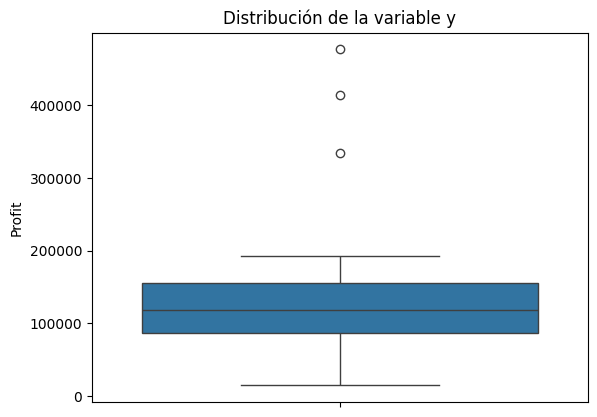

In [2355]:
plt.title('Distribución de la variable y')
sns.boxplot(df1['Profit']);

Se notó que la variable y presentaba outliers

In [2254]:
df1[df1['Profit'] > 300000]

,RyD_Spend,Administration,MarketingSpend,State,Profit
997,100275.47,241926.31,227142.82,California,413956.48
998,128456.23,321652.14,281692.32,California,333962.19
999,161181.72,270939.86,295442.17,New York,476485.43


In [2255]:
df1 = df1[df1['Profit'] < 300000]

Se eliminaron los 3 outliers, porque estos se alejaban mucho de la mediana

**Valores duplicados**

In [2256]:
df1.duplicated().values.any()

np.True_

In [2257]:
df1 = df1.drop_duplicates()

**Valores faltantes**

In [2258]:
df1.isna().sum()

RyD_Spend         0
Administration    0
MarketingSpend    0
State             0
Profit            0
dtype: int64

**Codificación de variables catgorícas**

In [2259]:
df1 = pd.get_dummies(data=df1, columns=['State'])

cols_bool = ['State_California', 'State_Florida', 'State_New York']
df1[cols_bool] = df1[cols_bool].astype('int')

df1

,RyD_Spend,Administration,MarketingSpend,Profit,State_California,State_Florida,State_New York
0,165349.20,136897.8000,471784.1000,192261.83000,0,0,1
1,162597.70,151377.5900,443898.5300,191792.06000,1,0,0
2,153441.51,101145.5500,407934.5400,191050.39000,0,1,0
3,144372.41,118671.8500,383199.6200,182901.99000,0,0,1
4,142107.34,91391.7700,366168.4200,166187.94000,0,1,0
...,...,...,...,...,...,...,...
992,105127.00,125982.7298,271621.8728,138841.98810,0,1,0
993,46798.00,117368.4374,159075.9080,89012.02672,1,0,0
994,97209.00,124813.3635,256344.0701,132077.70900,0,0,1
995,54135.00,118451.9990,173232.6695,95279.96251,1,0,0


In [2260]:
X1 = df1.drop(columns=['Profit'])
y1 = df1['Profit']

In [2261]:
X_train1, X_test1, y_train1, y_test1  = train_test_split(X1, y1, test_size=0.2, random_state=13)
X_train4, X_test4, y_train4, y_test4  = train_test_split(X1, y1, test_size=0.3, random_state=13)

**Distribuciones  y correlaciones de las variables**

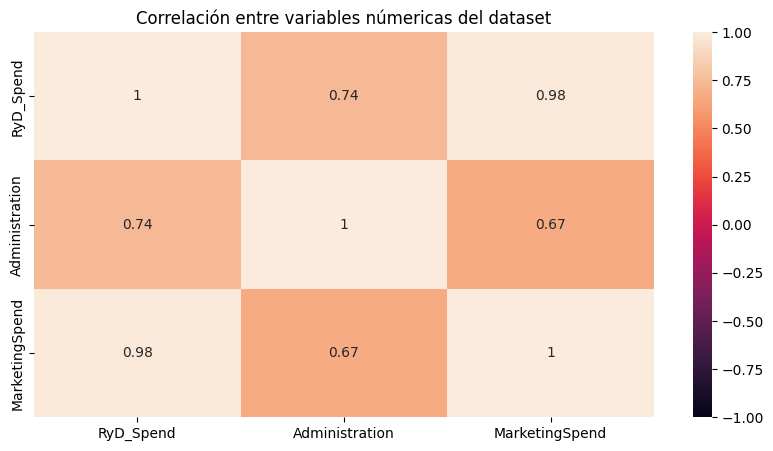

In [2262]:
columnas_numericas = ['RyD_Spend', 'Administration', 'MarketingSpend']

plt.figure(figsize=(10,5))
sns.heatmap(X_train1[columnas_numericas].corr(), vmin=-1, vmax=1, annot=True)
plt.title('Correlación entre variables númericas del dataset')
plt.show()

A partir del gráfico se observa que las variables numéricas del dataset presentan únicamente correlaciones positivas. La variable RyD_Spend presenta una fuerte correlación positiva con Administration de 0.74, y además tiene la correlación más fuerte de 0.98 con con MarketingSpend.

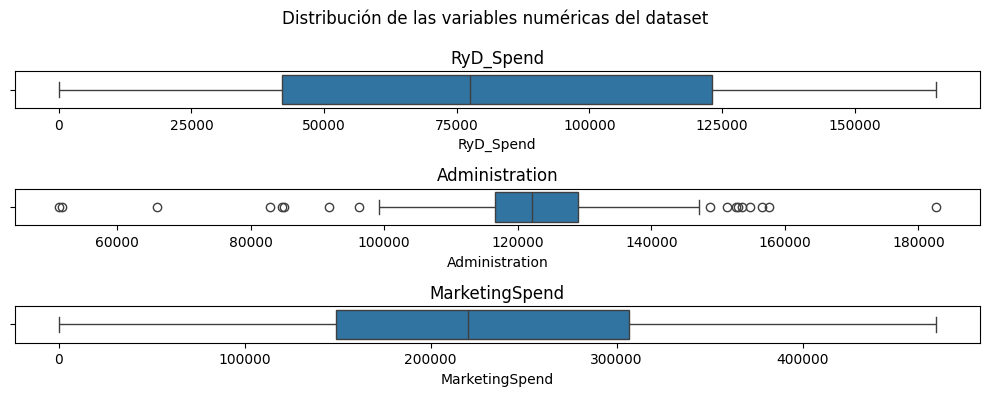

In [2263]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 4))

axes = axes.flatten()

for i, col in enumerate(columnas_numericas):
    sns.boxplot(x=X_train1[col], ax=axes[i], orient='h')
    axes[i].set_title(col)

fig.suptitle('Distribución de las variables numéricas del dataset')
plt.tight_layout()
plt.show()

Observando el gráfico de las distribución de las variables numéricas del dataset podemos ver que:
* Las variables RyD_Spend y MarketingSpend no presentan valores atípicos.
* La variable Administration presenta valores atípicos, que decidimos filtrar.

**Outliers**

In [2264]:
# Primer dataset (80,20)
winsor = Winsorizer(capping_method='iqr', tail='both',fold=3)

X_train1[columnas_numericas] = winsor.fit_transform(X_train1[columnas_numericas])
X_test1[columnas_numericas] = winsor.transform(X_test1[columnas_numericas])

# Segundo dataset (70,20)
winsor2 = Winsorizer(capping_method='iqr', tail='both',fold=3)

X_train4[columnas_numericas] = winsor2.fit_transform(X_train4[columnas_numericas])
X_test4[columnas_numericas] = winsor2.transform(X_test4[columnas_numericas])

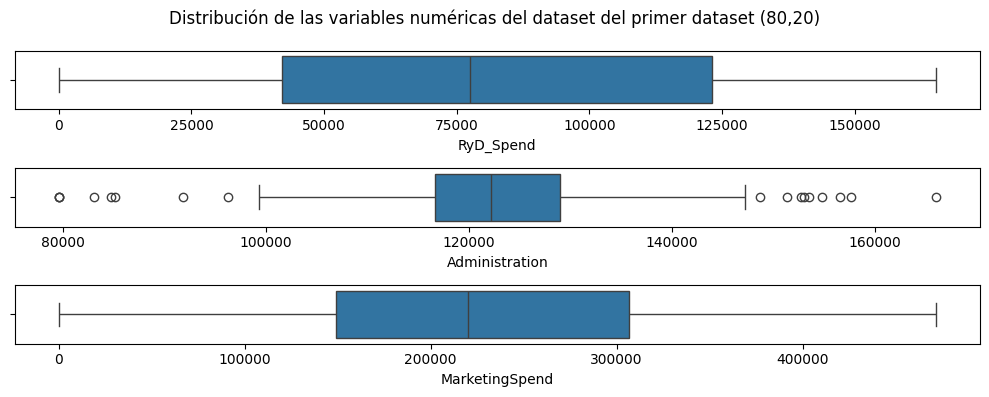

In [2265]:
fig, axes = plt.subplots(nrows=3, ncols=1, sharey=False, figsize=(10, 4))

for i, col in enumerate(columnas_numericas, 1):
    sns.boxplot(data=X_train1, x=col, ax=axes.flatten()[i-1])

for i in range(4, 4):
    axes.flatten()[i-1].axis('off')

fig.suptitle('Distribución de las variables numéricas del dataset del primer dataset (80,20)')
plt.tight_layout()
plt.show()

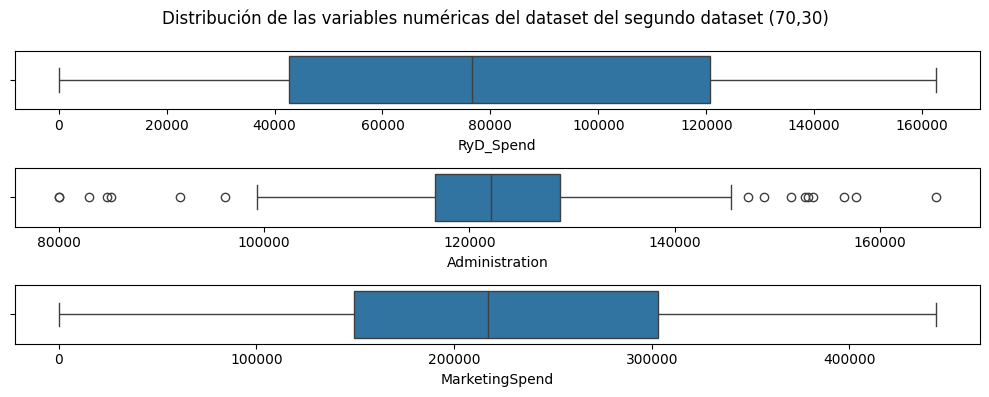

In [2266]:
fig, axes = plt.subplots(nrows=3, ncols=1, sharey=False, figsize=(10, 4))

for i, col in enumerate(columnas_numericas, 1):
    sns.boxplot(data=X_train4, x=col, ax=axes.flatten()[i-1])

for i in range(4, 4):
    axes.flatten()[i-1].axis('off')

fig.suptitle('Distribución de las variables numéricas del dataset del segundo dataset (70,30)')
plt.tight_layout()
plt.show()

## Árbol de decisión

**Modelo base**

In [2267]:
modelo_base1 = DecisionTreeRegressor(max_depth=None)

modelo_base1.fit(X_train1, y_train1);

Definimos un modelo base dejando max_depth=None para que el árbol crezca completamente, para después compararlo con el modelo optimizado y analizar cómo se realiza la poda.

**Optimización del árbol**

In [2268]:
param_grid = {
    'max_depth': [5, 7, 10, 15, 20, None],
    'min_samples_split': [2, 5, 7, 10],
    'min_samples_leaf': [1, 5, 7, 10],
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
}

modelo_semilla = DecisionTreeRegressor(random_state=42)

random_search = RandomizedSearchCV(modelo_semilla, param_distributions=param_grid, random_state=42)
random_search.fit(X_train1, y_train1)

# Guardamos los mejores hiperparámetros encontrados durante la búsqueda aleatoria
first_best_params = random_search.best_params_
print(f'{first_best_params}')

{'min_samples_split': 2, 'min_samples_leaf': 7, 'max_depth': 15, 'criterion': 'squared_error'}


**Mejor modelo**

In [2269]:
max_depth = first_best_params['max_depth']
criterion = first_best_params['criterion']
min_samples_leaf = first_best_params['min_samples_leaf']
min_samples_split = first_best_params['min_samples_split']

tree_reg = DecisionTreeRegressor(criterion=criterion, 
                                  max_depth=max_depth,
                                  min_samples_leaf=min_samples_leaf, 
                                  min_samples_split=min_samples_split,
                                  random_state=13)

### Dataset 1 (80, 20)

In [2270]:
tree_reg.fit(X_train1, y_train1)

,criterion,'squared_error'
,splitter,'best'
,max_depth,15
,min_samples_split,2
,min_samples_leaf,7
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,13
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [2271]:
pred_train = tree_reg.predict(X_train1)

pred_test = tree_reg.predict(X_test1)

tableResult(y_test1, pred_test).head(5)

,Actual,Predicted
206,159509.00490,159029.429027
780,144130.05170,143795.413543
417,80082.11902,80284.586073
870,50428.81124,44071.062999
988,83178.92524,84323.281386


### Visualización

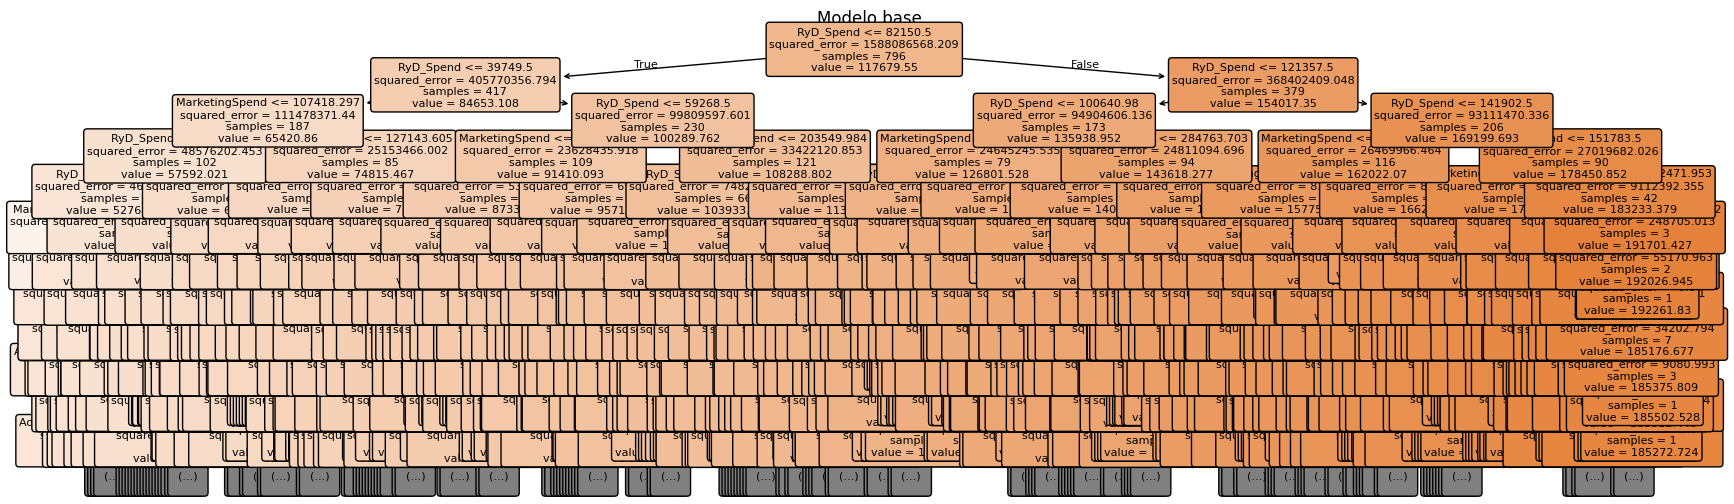

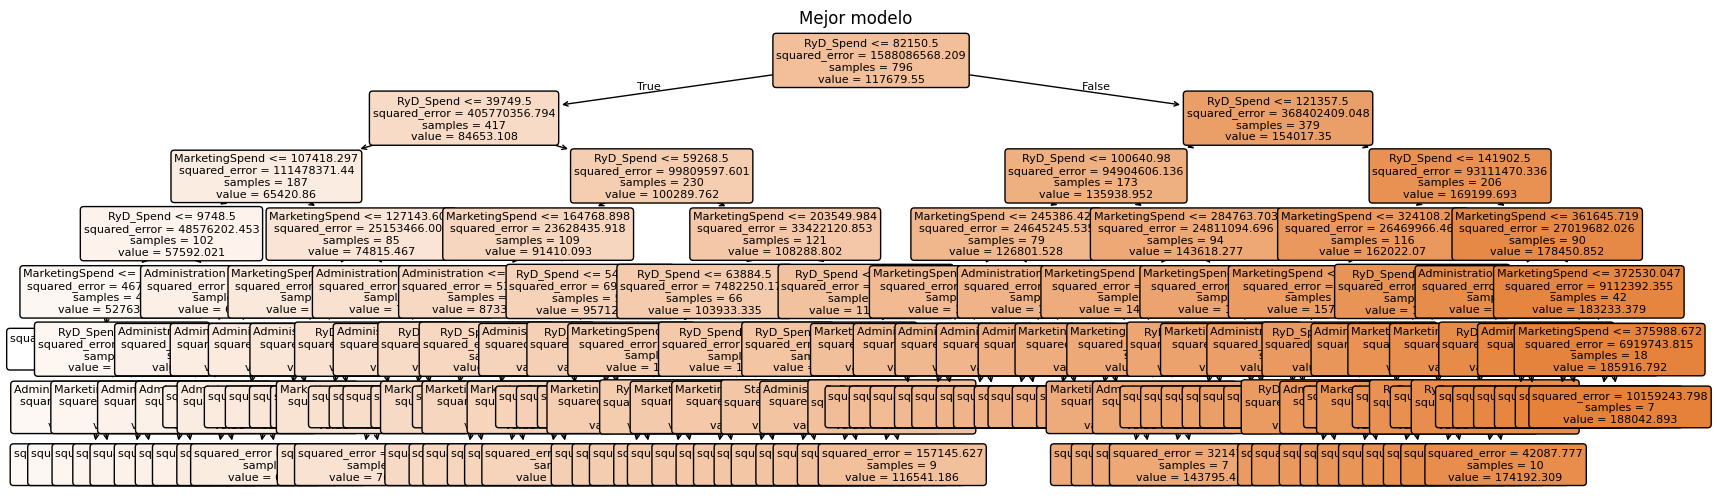

In [2272]:
# Modelo base
plt.figure(figsize=(20,6))
plot_tree(modelo_base1, feature_names=X_train1.columns, fontsize=8, filled=True, rounded=True, max_depth=11)
plt.title('Modelo base')  
plt.show()

# Mejor modelo
plt.figure(figsize=(20,6))
plot_tree(tree_reg, feature_names=X_train1.columns, fontsize=8, filled=True, rounded=True, max_depth=11)
plt.title('Mejor modelo') 
plt.show()

In [2273]:
# Obtenemos las profundidades de los árboles  
profundidad_modelo_base1 = modelo_base1.get_depth()
profundidad_tree_reg = tree_reg.get_depth()

print(f'profundidad del modelo base: {profundidad_modelo_base1}')
print(f'profundidad del mejor modelo: {profundidad_tree_reg}')

profundidad del modelo base: 14
profundidad del mejor modelo: 7


A partir de la comparación entre los dos árboles de decisión de los modelos, podemos notar una mejora en el segundo modelo debido a que se realizó una poda, donde se reduce a la mitad la longitud del árbol, evitando overfitting.

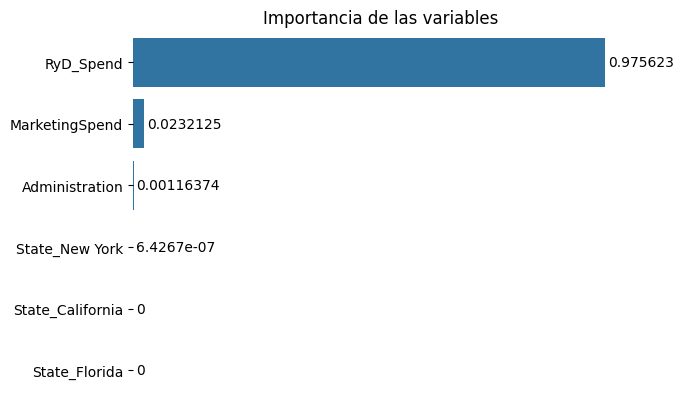

In [2274]:
features_df = pd.DataFrame({'features': X_train1.columns, 'importances': tree_reg.feature_importances_ })

features_df_sorted = features_df.sort_values(by='importances', ascending=False)

g = sns.barplot(data=features_df_sorted, x='importances', y ='features')
sns.despine(bottom = True, left = True)
g.set_title('Importancia de las variables')
g.set(xlabel=None, ylabel=None, xticks=[])
for value in g.containers:
    g.bar_label(value, padding=2)

El gráfico de importancia de variables muestra que si bien se utilizan 4 variables para realizar la predicción, la variable RyD_Spend es por amplio margen la que más influye, mientras que MarketingSpend, Administration, State_New York tienen un impacto casi nulo.

### Métricas

In [2275]:
print('Error absoluto medio (MAE):', mean_absolute_error(y_test1, pred_test))
print('Error medio cuadrado (MSE):', mean_squared_error(y_test1, pred_test))
print('Raíz del error medio cuadrado (RMSE):', np.sqrt(mean_squared_error(y_test1, pred_test)))
print("Porcentaje de error medio absoluto (MAPE):", np.mean(np.abs((y_test1 - pred_test) / y_test1) * 100))

Error absoluto medio (MAE): 911.1773444110565
Error medio cuadrado (MSE): 7491876.304477347
Raíz del error medio cuadrado (RMSE): 2737.129208582844
Porcentaje de error medio absoluto (MAPE): 0.998106435318613


Entre las métricas del modelo podemos notar que:
* En promedio la predicción se aleja por 2737 unidades sobre el precio real.
* En promedio la predicciones se desvían 911 unidades.

Cuando RMSE > MAE, significa que hay algunos errores grandes que están tirando el RMSE hacia arriba (outliers).

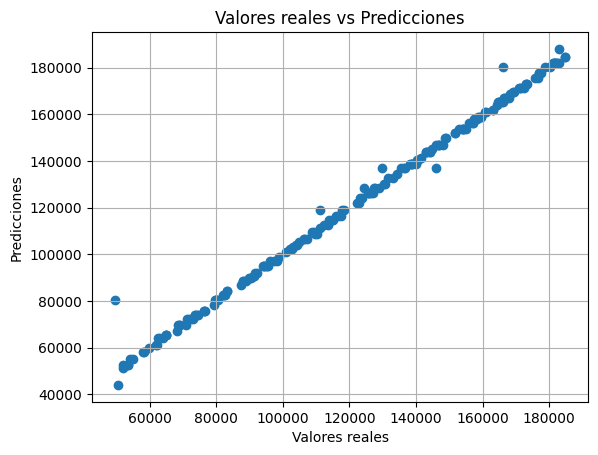

In [2356]:
plt.scatter(y_test1, pred_test)
plt.xlabel("Valores reales")
plt.ylabel("Predicciones")
plt.title("Valores reales vs Predicciones")
plt.grid(visible=True)
plt.show()

En este gráfico podemos notar que hay algunos valores que el modelo que el modelo no puede predecir correctamente, por lo cual vemos valores de residuos que se alejan de la recta. 

### Dataset 2 (70, 30)

In [2277]:
tree_reg.fit(X_train4, y_train4)

,criterion,'squared_error'
,splitter,'best'
,max_depth,15
,min_samples_split,2
,min_samples_leaf,7
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,13
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [2278]:
pred_train4 = tree_reg.predict(X_train4)

pred_test4 = tree_reg.predict(X_test4)

tableResult(y_test4, pred_test4)

,Actual,Predicted
206,159509.00490,158909.417231
780,144130.05170,143795.413543
417,80082.11902,79928.631336
870,50428.81124,42080.816160
988,83178.92524,84323.281386
...,...,...
318,96793.76682,97226.610367
611,154190.18690,153060.954043
800,174421.51510,174142.161837
363,91240.87291,92340.674474


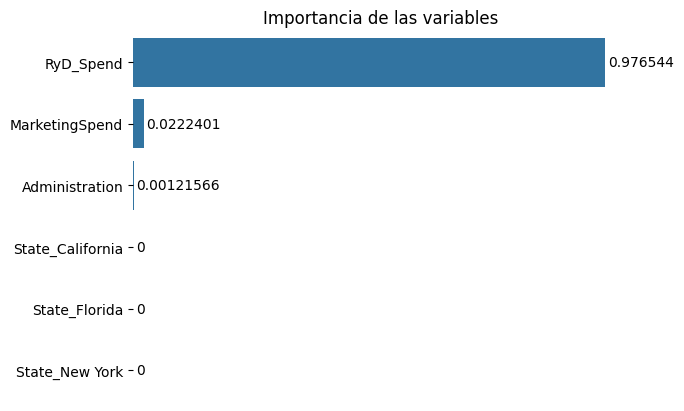

In [2279]:
features_df = pd.DataFrame({'features': X_train4.columns, 'importances': tree_reg.feature_importances_ })

features_df_sorted = features_df.sort_values(by='importances', ascending=False)

g = sns.barplot(data=features_df_sorted, x='importances', y ='features')
sns.despine(bottom = True, left = True)
g.set_title('Importancia de las variables')
g.set(xlabel=None, ylabel=None, xticks=[])
for value in g.containers:
    g.bar_label(value, padding=2)

El gráfico de importancia de variables muestra que si bien se utilizan 3 variables para realizar la predicción, la variable RyD_Spend es por amplio margen la que más influye, mientras que MarketingSpend, Administration, State_New York tienen un impacto casi nulo.

### Métricas

In [2280]:
print('Error absoluto medio (MAE):', mean_absolute_error(y_test4, pred_test4))
print('Error medio cuadrado (MSE):', mean_squared_error(y_test4, pred_test4))
print('Raíz del error medio cuadrado (RMSE):', np.sqrt(mean_squared_error(y_test4, pred_test4)))
print("Porcentaje de error medio absoluto (MAPE):", np.mean(np.abs((y_test4 - pred_test4) / y_test4) * 100))

Error absoluto medio (MAE): 954.9828764187314
Error medio cuadrado (MSE): 7360253.176520517
Raíz del error medio cuadrado (RMSE): 2712.9786539006377
Porcentaje de error medio absoluto (MAPE): 1.0472388661546816


A comparación del entrenamiento del modelo con el dataset anterior, en este caso las métricas relacionadas al error dieron números menores, demostrando que el modelo mejoró al ser entrenado con menos datos.

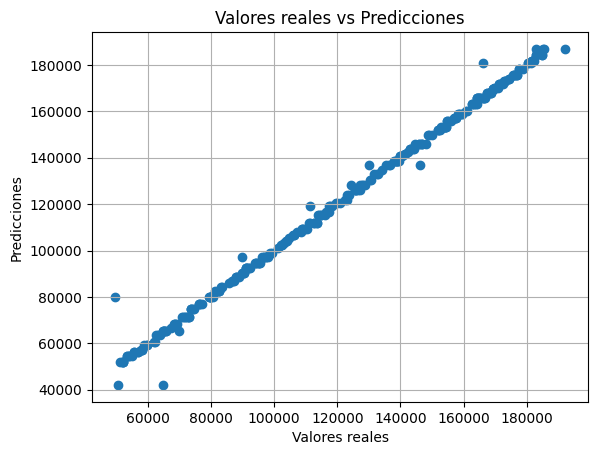

In [2357]:
plt.scatter(y_test4, pred_test4)
plt.xlabel("Valores reales")
plt.ylabel("Predicciones")
plt.title("Valores reales vs Predicciones")
plt.grid(visible=True)
plt.show()

La distribución de los residuos es similar al modelo entrenado con el split anterior de los datos, donde vemos algunos valores que no puede predecir correctamente.

# Segundo dataset

## Análisis exploratorio de datos (EDA)

In [2282]:
dataset2 = pd.read_csv('drugType.csv')

In [2283]:
#Creamos copia del dataset original
df2 = dataset2.copy()

df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Edad        200 non-null    int64  
 1   Sexo        200 non-null    object 
 2   BP          200 non-null    object 
 3   Colesterol  200 non-null    object 
 4   Na_a_K      200 non-null    float64
 5   Droga       200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


In [2284]:
df2.head()

,Edad,Sexo,BP,Colesterol,Na_a_K,Droga
0,23,F,Alto,Alto,25.355,DrogaY
1,47,M,Bajo,Alto,13.093,DrogaC
2,47,M,Bajo,Alto,10.114,DrogaC
3,28,F,Normal,Alto,7.798,DrogaX
4,61,F,Bajo,Alto,18.043,DrogaY


In [2285]:
df2.describe()

,Edad,Na_a_K
count,200.000000,200.000000
mean,44.315000,16.084485
std,16.544315,7.223956
min,15.000000,6.269000
25%,31.000000,10.445500
50%,45.000000,13.936500
75%,58.000000,19.380000
max,74.000000,38.247000


**Valores duplicados**

In [2286]:
df2.duplicated().values.any()

np.False_

**Valores faltantes**

In [2287]:
df2.isna().sum()

Edad          0
Sexo          0
BP            0
Colesterol    0
Na_a_K        0
Droga         0
dtype: int64

**Codificación de variables categóricas**

In [2288]:
# Convertir columnas categóricas en numéricas
df2 = pd.get_dummies(data=df2, columns=['Sexo', 'BP', 'Colesterol'])

cols_bool = ['Sexo_F', 'Sexo_M', 'BP_Alto', 'BP_Bajo', 'BP_Normal', 'Colesterol_Alto', 'Colesterol_Normal']
df2[cols_bool] = df2[cols_bool].astype('int')

df2.head()

,Edad,Na_a_K,Droga,Sexo_F,Sexo_M,BP_Alto,BP_Bajo,BP_Normal,Colesterol_Alto,Colesterol_Normal
0,23,25.355,DrogaY,1,0,1,0,0,1,0
1,47,13.093,DrogaC,0,1,0,1,0,1,0
2,47,10.114,DrogaC,0,1,0,1,0,1,0
3,28,7.798,DrogaX,1,0,0,0,1,1,0
4,61,18.043,DrogaY,1,0,0,1,0,1,0


**Análisis del balanceo del dataset**

In [2289]:
conteo = df2['Droga'].value_counts()

df_balanceo = pd.DataFrame({
    'Conteo': conteo,
    'Frecuencia de aparición': conteo / conteo.sum() * 100
})

df_balanceo

,Conteo,Frecuencia de aparición
Droga,,
DrogaY,91,45.5
DrogaX,54,27.0
DrogaA,23,11.5
DrogaC,16,8.0
DrogaB,16,8.0


A partir de la tabla, se puede afirmar que el dataset está desbalanceado, ya que la clase DrogaY es ampliamente la más frecuente, seguida de DrogaX con 54 observaciones, mientras que las clases DrogaA, DrogaB y DrogaC aparecen significativamente menos, sumando entre ellas el 27,5% de frecuencia acumulada de aparición.

**División test - train**

In [2290]:
X2 = df2.drop(columns=['Droga'])
y2 = df2['Droga']

In [2291]:
X_train2, X_test2, y_train2, y_test2  = train_test_split(X2, y2, test_size=0.2, random_state=13, shuffle=True, stratify=y2)
X_train3, X_test3, y_train3, y_test3  = train_test_split(X2, y2, test_size=0.3, random_state=13, shuffle=True, stratify=y2)

**Escalado de datos**

In [2292]:
X_train_scaled2 = X_train2.copy()
X_test_scaled2 = X_test2.copy()

scaler = StandardScaler()

X_train_scaled2[['Edad', 'Na_a_K']] = scaler.fit_transform(X_train2[['Edad', 'Na_a_K']])
X_test_scaled2[['Edad', 'Na_a_K']] = scaler.transform(X_test2[['Edad', 'Na_a_K']])

X_train_scaled2.head()

,Edad,Na_a_K,Sexo_F,Sexo_M,BP_Alto,BP_Bajo,BP_Normal,Colesterol_Alto,Colesterol_Normal
83,-0.362829,-0.665798,1,0,1,0,0,0,1
65,1.453207,1.522411,1,0,0,0,1,0,1
74,-0.786571,0.133419,0,1,1,0,0,0,1
7,-0.181225,-0.706016,0,1,0,1,0,1,0
80,0.968931,-0.302859,0,1,1,0,0,1,0


In [2293]:
X_train_scaled3 = X_train3.copy()
X_test_scaled3 = X_test3.copy()

X_train_scaled3[['Edad', 'Na_a_K']] = scaler.fit_transform(X_train3[['Edad', 'Na_a_K']])
X_test_scaled3[['Edad', 'Na_a_K']] = scaler.transform(X_test3[['Edad', 'Na_a_K']])

X_train_scaled3.head()

,Edad,Na_a_K,Sexo_F,Sexo_M,BP_Alto,BP_Bajo,BP_Normal,Colesterol_Alto,Colesterol_Normal
39,-1.725205,-0.990332,0,1,0,0,1,1,0
129,-0.699477,-1.222585,1,0,0,0,1,1,0
71,-0.940825,0.540342,1,0,0,0,1,1,0
174,-0.096108,-0.458187,0,1,1,0,0,0,1
125,-1.483857,1.449988,1,0,1,0,0,0,1


**Distribuciones y correlaciones de las variables**

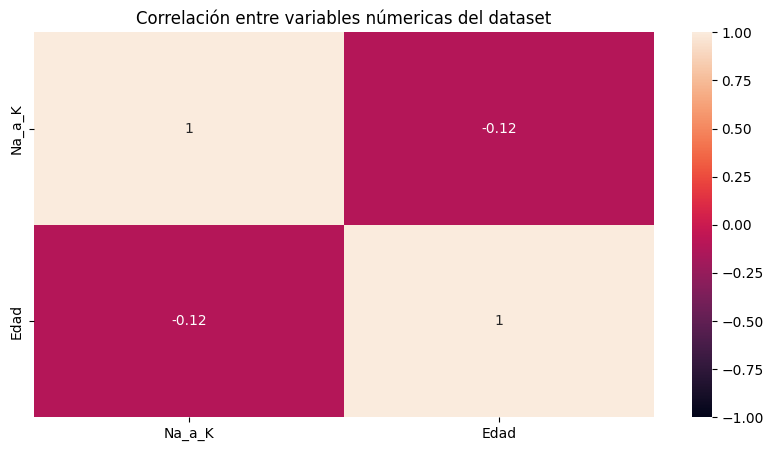

In [2294]:
columnas_numericas2 = ['Na_a_K', 'Edad']

plt.figure(figsize=(10,5))
sns.heatmap(X_train2[columnas_numericas2].corr(), vmin=-1, vmax=1, annot=True)
plt.title('Correlación entre variables númericas del dataset')
plt.show()

La correlación lineal entre Edad y Na_a_K es negativa y muy débil, lo que nos indica que no presentan una asociación significativa.

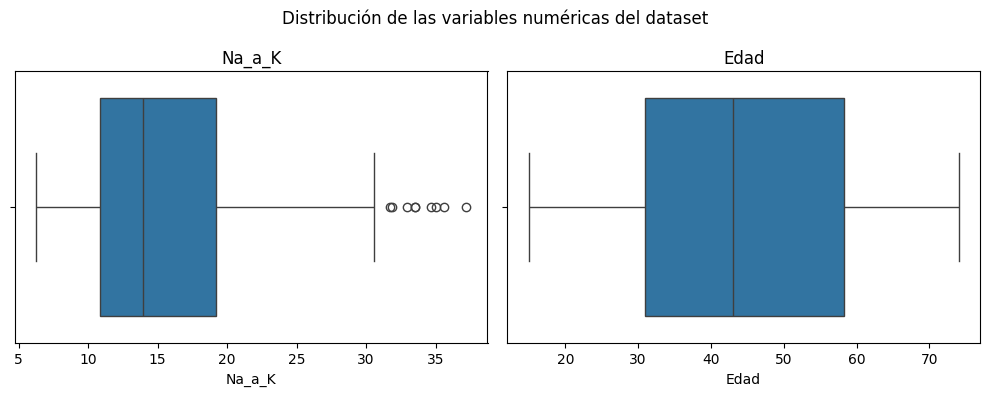

In [2358]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axes = axes.flatten()

for i, col in enumerate(columnas_numericas2):
    sns.boxplot(x=X_train2[col], ax=axes[i], orient='h')
    axes[i].set_title(col)

fig.suptitle('Distribución de las variables numéricas del dataset')
plt.tight_layout()
plt.show()

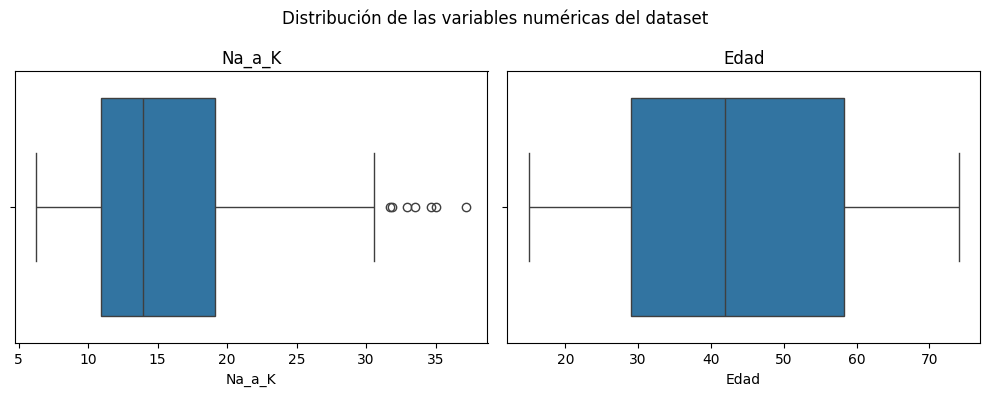

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axes = axes.flatten()

for i, col in enumerate(columnas_numericas2):
    sns.boxplot(x=X_train3[col], ax=axes[i], orient='h')
    axes[i].set_title(col)

fig.suptitle('Distribución de las variables numéricas del dataset')
plt.tight_layout()
plt.show()

Observando el gráfico de las distribución de las variables numéricas del dataset podemos ver que para la variable Edad no encontramos valores atípicos, mientras que para la variable Na_a_k si bien se encontraron valores atípicos, estos no son imposibles por lo cual no decidimos filtrarlos.

## Árbol de decisión

**Modelo base**

In [2297]:
modelo_base = DecisionTreeClassifier(max_depth=None)

modelo_base.fit(X_train2, y_train2);

Definimos un modelo base dejando max_depth=None para que el árbol crezca completamente, para después compararlo con el modelo optimizado y analizar cómo se realiza la poda.

**Optimización de hiperparámetros**

In [2361]:
param_grid = {
    'max_depth': [5, 7, 10, 15, None],
    'min_samples_split': [3, 5, 7, 9, 11, 13, 15],
    'min_samples_leaf': [3, 5, 7, 9, 11, 13, 15],
    'criterion': ['entropy', 'log_loss', 'gini'],
}
random_search = RandomizedSearchCV(DecisionTreeClassifier(), param_distributions=param_grid, random_state=42)
random_search.fit(X_train2, y_train2)

# Mejores hiperparámetros encontrados durante la búsqueda aleatoria
first_best_params = random_search.best_params_

print(f'{first_best_params}')

{'min_samples_split': 15, 'min_samples_leaf': 7, 'max_depth': 7, 'criterion': 'gini'}


**Mejor modelo**

In [2362]:
max_depth = first_best_params['max_depth']
criterion = first_best_params['criterion']
min_samples_leaf = first_best_params['min_samples_leaf']
min_samples_split = first_best_params['min_samples_split']

tree_clf = DecisionTreeClassifier(criterion=criterion, 
                                  max_depth=max_depth,
                                  min_samples_leaf=min_samples_leaf, 
                                  min_samples_split=min_samples_split,
                                  random_state=13, 
                                  class_weight= 'balanced')

### Dataset 1: (80, 20)

In [2363]:
tree_clf.fit(X_train2, y_train2)

,criterion,'gini'
,splitter,'best'
,max_depth,7
,min_samples_split,15
,min_samples_leaf,7
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,13
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,'balanced'


In [2364]:
pred_train = tree_clf.predict(X_train2)

pred_test2 = tree_clf.predict(X_test2)

tableResult(y_test2, pred_test2).head()

,Actual,Predicted
19,DrogaY,DrogaY
50,DrogaY,DrogaY
99,DrogaY,DrogaY
41,DrogaB,DrogaB
30,DrogaX,DrogaX


**Visualización**

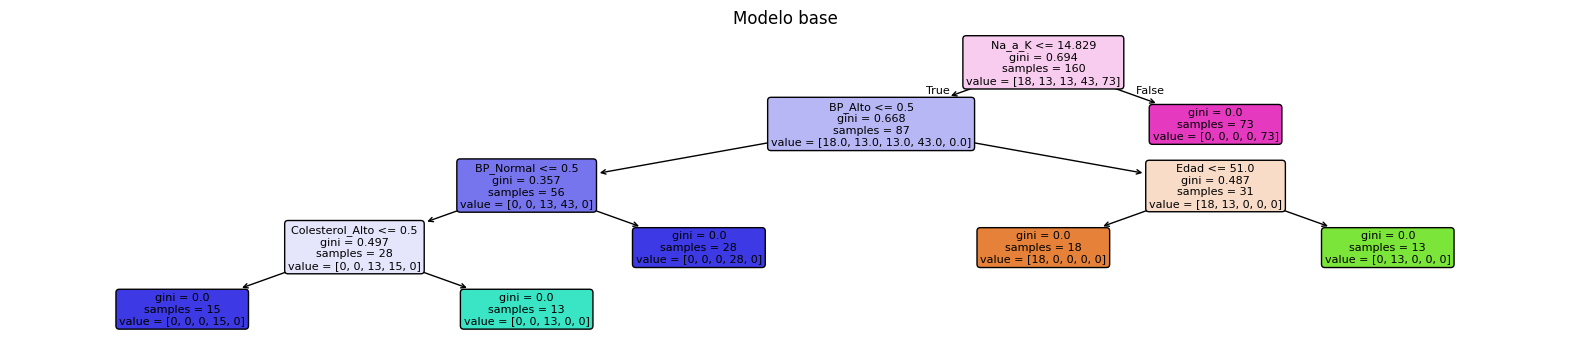

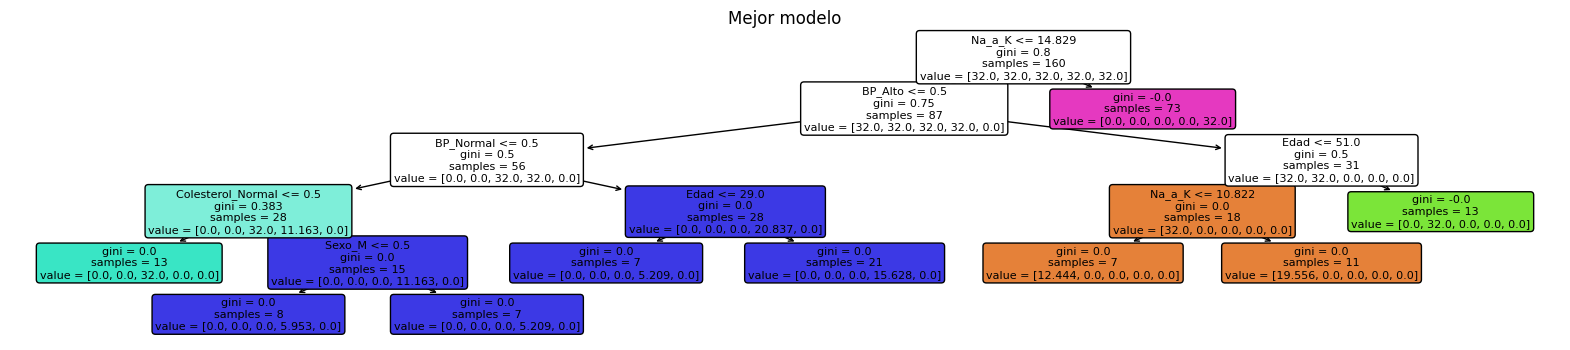

In [2302]:
# Modelo base
plt.figure(figsize=(20,4))
plot_tree(modelo_base, feature_names=X_train2.columns, fontsize=8, filled=True, rounded=True)
plt.title('Modelo base')  
plt.show()

# Mejor modelo
plt.figure(figsize=(20,4))
plot_tree(tree_clf, feature_names=X_train2.columns, fontsize=8, filled=True, rounded=True)
plt.title('Mejor modelo')
plt.show()

In [2367]:
# Obtenemos las profundidades de los árboles  
profundidad_modelo_base = modelo_base.get_depth()
profundidad_tree_clf = tree_clf.get_depth()

print(f'profundidad del modelo base: {profundidad_modelo_base}')
print(f'profundidad del mejor modelo: {profundidad_tree_clf}')

profundidad del modelo base: 4
profundidad del mejor modelo: 5


árbol ligeramente más profundo puede capturar patrones más complejos que un árbol limitado a los valores por defecto, mejorando la predicción sin sobreajustar demasiado.

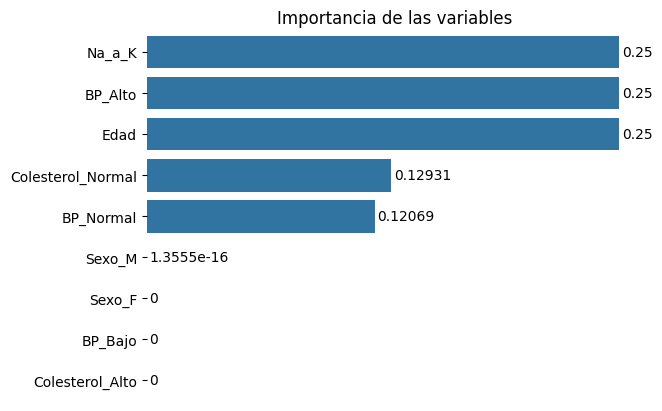

In [2304]:
features_df = pd.DataFrame({'features': X_train2.columns, 'importances': tree_clf.feature_importances_ })

features_df_sorted = features_df.sort_values(by='importances', ascending=False)

g = sns.barplot(data=features_df_sorted, x='importances', y ='features')
sns.despine(bottom = True, left = True)
g.set_title('Importancia de las variables')
g.set(xlabel=None, ylabel=None, xticks=[])
for value in g.containers:
    g.bar_label(value, padding=2)

A partir del gráfico podemos notar que sólo algunas de las variables del dataset contribuyen significativamente a las predicciones del modelo, entre ellas, las variables Na_a_K, BP_Alto y Edad, son igualmente de importantes, con el valor de importancia más alto (0.25). Las variables Colesterol_Normal y BP_Normal tienen un peso considerable, aunque menor. Por otro lado, se puede notar que el Sexo, BP_Bajo y Colesterol_Alto presentan una importancia cercana o igual a cero, lo que indica que no están siendo utilizadas por el modelo para tomar decisiones de predicción.

**Métricas**

In [2305]:
print('Accuracy:', accuracy_score(y_test2, pred_test2))
print('Precisión:', precision_score(y_test2, pred_test2, average='weighted'))
print('Recall:', recall_score(y_test2, pred_test2, average='weighted'))
print("F1:", f1_score(y_test2, pred_test2, average='weighted'))

print('\nInforme de Clasificación:')
print(classification_report(y_test2, pred_test2))

Accuracy: 0.975
Precisión: 0.9791666666666667
Recall: 0.975
F1: 0.9736363636363636

Informe de Clasificación:
              precision    recall  f1-score   support

      DrogaA       0.83      1.00      0.91         5
      DrogaB       1.00      0.67      0.80         3
      DrogaC       1.00      1.00      1.00         3
      DrogaX       1.00      1.00      1.00        11
      DrogaY       1.00      1.00      1.00        18

    accuracy                           0.97        40
   macro avg       0.97      0.93      0.94        40
weighted avg       0.98      0.97      0.97        40



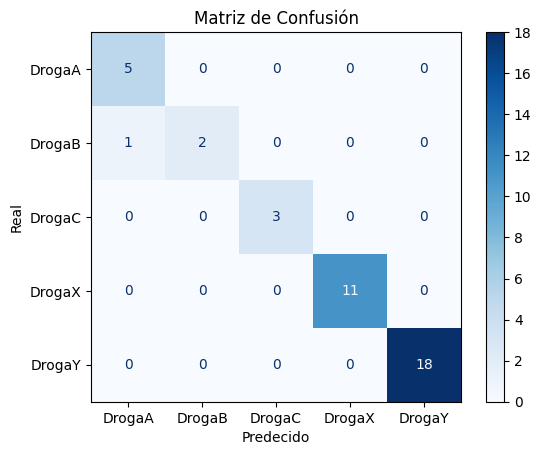

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test2, pred_test2, cmap=plt.cm.Blues)
plt.xlabel('Predecido')
plt.ylabel('Real')
plt.title('Matriz de Confusión');

### Dataset 2: (70, 30)

In [2307]:
tree_clf.fit(X_train3, y_train3)

,criterion,'gini'
,splitter,'best'
,max_depth,7
,min_samples_split,15
,min_samples_leaf,7
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,13
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,'balanced'


In [2308]:
pred_train3 = tree_clf.predict(X_train3)

pred_test3 = tree_clf.predict(X_test3)

tableResult(y_test3, pred_test3).head()

,Actual,Predicted
93,DrogaY,DrogaY
35,DrogaX,DrogaX
150,DrogaA,DrogaA
152,DrogaX,DrogaX
137,DrogaA,DrogaA


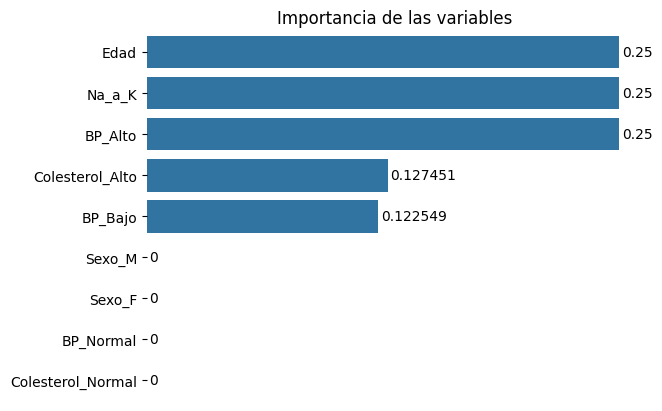

In [2309]:
features_df = pd.DataFrame({'features': X_train3.columns, 'importances': tree_clf.feature_importances_ })

features_df_sorted = features_df.sort_values(by='importances', ascending=False)

g = sns.barplot(data=features_df_sorted, x='importances', y ='features')
sns.despine(bottom = True, left = True)
g.set_title('Importancia de las variables')
g.set(xlabel=None, ylabel=None, xticks=[])
for value in g.containers:
    g.bar_label(value, padding=2)

**Métricas**

In [2310]:
print('Accuracy:', accuracy_score(y_test3, pred_test3))
print('Precisión:', precision_score(y_test3, pred_test3, average='weighted'))
print('Recall:', recall_score(y_test3, pred_test3, average='weighted'))
print("F1:", f1_score(y_test3, pred_test3, average='weighted'))

print('Informe de Clasificación:')
print(classification_report(y_test3, pred_test3))

Accuracy: 0.9833333333333333
Precisión: 0.9854166666666667
Recall: 0.9833333333333333
F1: 0.9829629629629629
Informe de Clasificación:
              precision    recall  f1-score   support

      DrogaA       0.88      1.00      0.93         7
      DrogaB       1.00      0.80      0.89         5
      DrogaC       1.00      1.00      1.00         5
      DrogaX       1.00      1.00      1.00        16
      DrogaY       1.00      1.00      1.00        27

    accuracy                           0.98        60
   macro avg       0.97      0.96      0.96        60
weighted avg       0.99      0.98      0.98        60



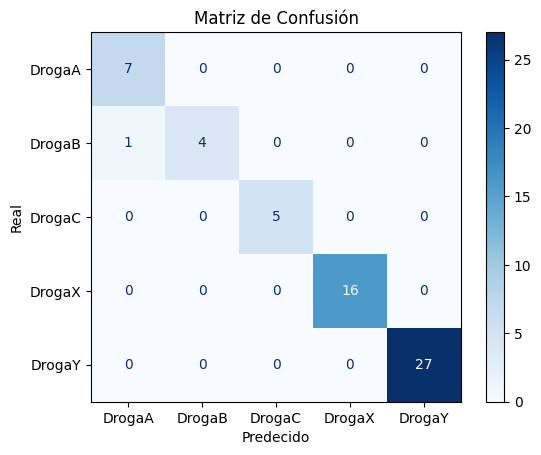

In [2340]:
ConfusionMatrixDisplay.from_predictions(y_test3, pred_test3, cmap=plt.cm.Blues)
plt.xlabel('Predecido')
plt.ylabel('Real')
plt.title('Matriz de Confusión');

## Multinomial Naïve Bayes

In [2312]:
bayes1_test = X_test2.copy()
bayes1_train = X_train2.copy()

bayes2_test = X_test3.copy()
bayes2_train = X_train3.copy()

### Dataset 1 (80, 20)

**Discretización de las variables númericas continuas**

In [2313]:
bayes1_test['edad_menor25'] = (bayes1_test['Edad'] < 25).astype(int)
bayes1_test['edad_25_50'] = ((bayes1_test['Edad'] >= 25) & (bayes1_test['Edad'] < 50)).astype(int)
bayes1_test['edad_50_75'] = ((bayes1_test['Edad'] >= 50) & (bayes1_test['Edad'] < 75)).astype(int)
bayes1_test['edad_mayor75'] = (bayes1_test['Edad'] >= 75).astype(int)

bayes1_train['edad_menor25'] = (bayes1_train['Edad'] < 25).astype(int)
bayes1_train['edad_25_50'] = ((bayes1_train['Edad'] >= 25) & (bayes1_train['Edad'] < 50)).astype(int)
bayes1_train['edad_50_75'] = ((bayes1_train['Edad'] >= 50) & (bayes1_train['Edad'] < 75)).astype(int)
bayes1_train['edad_mayor75'] = (bayes1_train['Edad'] >= 75).astype(int)

In [2314]:
bayes2_test['edad_menor25'] = (bayes2_test['Edad'] < 25).astype(int)
bayes2_test['edad_25_50'] = ((bayes2_test['Edad'] >= 25) & (bayes2_test['Edad'] < 50)).astype(int)
bayes2_test['edad_50_75'] = ((bayes2_test['Edad'] >= 50) & (bayes2_test['Edad'] < 75)).astype(int)
bayes2_test['edad_mayor75'] = (bayes2_test['Edad'] >= 75).astype(int)

bayes2_train['edad_menor25'] = (bayes2_train['Edad'] < 25).astype(int)
bayes2_train['edad_25_50'] = ((bayes2_train['Edad'] >= 25) & (bayes2_train['Edad'] < 50)).astype(int)
bayes2_train['edad_50_75'] = ((bayes2_train['Edad'] >= 50) & (bayes2_train['Edad'] < 75)).astype(int)
bayes2_train['edad_mayor75'] = (bayes2_train['Edad'] >= 75).astype(int)

In [2315]:
bayes2_test['NaK_bajo'] = (bayes2_test['Na_a_K'] < 10).astype(int)
bayes2_test['NaK_medio'] = ((bayes2_test['Na_a_K'] >= 10) & (bayes2_test['Na_a_K'] < 20)).astype(int)
bayes2_test['NaK_alto'] = (bayes2_test['Na_a_K'] >= 20).astype(int)

bayes2_train['NaK_bajo'] = (bayes2_train['Na_a_K'] < 10).astype(int)
bayes2_train['NaK_medio'] = ((bayes2_train['Na_a_K'] >= 10) & (bayes2_train['Na_a_K'] < 20)).astype(int)
bayes2_train['NaK_alto'] = (bayes2_train['Na_a_K'] >= 20).astype(int)

In [2316]:
bayes2_test['NaK_bajo'] = (bayes2_test['Na_a_K'] < 10).astype(int)
bayes2_test['NaK_medio'] = ((bayes2_test['Na_a_K'] >= 10) & (bayes2_test['Na_a_K'] < 20)).astype(int)
bayes2_test['NaK_alto'] = (bayes2_test['Na_a_K'] >= 20).astype(int)

bayes2_train['NaK_bajo'] = (bayes2_train['Na_a_K'] < 10).astype(int)
bayes2_train['NaK_medio'] = ((bayes2_train['Na_a_K'] >= 10) & (bayes2_train['Na_a_K'] < 20)).astype(int)
bayes2_train['NaK_alto'] = (bayes2_train['Na_a_K'] >= 20).astype(int)

In [2317]:
bayes1_train.drop(columns=['Edad', 'Na_a_K'], inplace=True)
bayes2_train.drop(columns=['Edad', 'Na_a_K'], inplace=True)

bayes1_test.drop(columns=['Edad', 'Na_a_K'], inplace=True)
bayes2_test.drop(columns=['Edad', 'Na_a_K'], inplace=True)

**Modelo**

In [2330]:
clf_MNB = MultinomialNB()
clf_MNB.fit(bayes1_train, y_train2)

# Realizamos las predicciones
pred_MNB2 = clf_MNB.predict(bayes1_test)

**Métricas**

In [2331]:
print('Accuracy:', accuracy_score(y_test2, pred_MNB2))
print('Precisión:', precision_score(y_test2, pred_MNB2, average='weighted'))
print('Recall:', recall_score(y_test2, pred_MNB2, average='weighted'))
print("F1:", f1_score(y_test2, pred_MNB2, average='weighted'))

print('Informe de Clasificación:')
print(classification_report(y_test2, pred_MNB2))

Accuracy: 0.575
Precisión: 0.5048076923076923
Recall: 0.575
F1: 0.5220779220779221
Informe de Clasificación:
              precision    recall  f1-score   support

      DrogaA       0.50      0.20      0.29         5
      DrogaB       0.00      0.00      0.00         3
      DrogaC       0.00      0.00      0.00         3
      DrogaX       0.73      0.73      0.73        11
      DrogaY       0.54      0.78      0.64        18

    accuracy                           0.57        40
   macro avg       0.35      0.34      0.33        40
weighted avg       0.50      0.57      0.52        40



c:\Users\Nico\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Nico\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Nico\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(averag

El modelo en general, cuenta con un buen recall y precision cercanos a 0.90, que nos indica que predice correctamente la mayoría de las clases de test, el F1 ponderado de 0.87 denota un equilibrio entre la precisión y el recall. 

Al analizar las métricas por clase, se observa que las clases minoritarias (DrogaA, DrogaB y DrogaC) presentan un desempeño más desigual: 
* DrogaA tiene precisión perfecta (1.00) pero recall bajo (0.60), indicando que el modelo predice correctamente esta clase cuando la asigna, pero no identifica todas sus instancias reales
* DrogaB muestra recall perfecto (1.00) pero precisión menor (0.75), 
* DrogaC combina alta precisión (1.00) con recall moderado (0.67). 

En contraste, las clases mayoritarias (DrogaX y DrogaY) presentan métricas equilibradas y elevadas, lo que demuestra que el modelo maneja correctamente las clases más frecuentes.

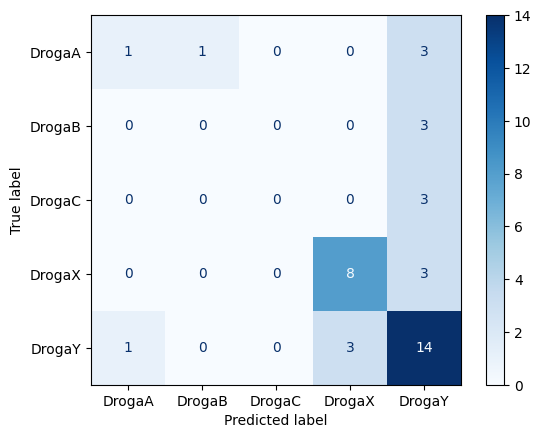

In [2320]:
ConfusionMatrixDisplay.from_predictions(y_test2, pred_MNB2, cmap=plt.cm.Blues);

### Dataset 2 (70, 20)

**Modelo**

In [2332]:
clf_MNB = MultinomialNB()
clf_MNB.fit(bayes2_train, y_train3)

# Realizamos las predicciones
pred_MNB3 = clf_MNB.predict(bayes2_test)

**Métricas**

In [2333]:
print('Accuracy:', accuracy_score(y_test3, pred_MNB3))
print('Precisión:', precision_score(y_test3, pred_MNB3, average='weighted'))
print('Recall:', recall_score(y_test3, pred_MNB3, average='weighted'))
print("F1:", f1_score(y_test3, pred_MNB3, average='weighted'))

print('Informe de Clasificación:')
print(classification_report(y_test3, pred_MNB3))

Accuracy: 0.7
Precisión: 0.7067320261437909
Recall: 0.7
F1: 0.6871170456548563
Informe de Clasificación:
              precision    recall  f1-score   support

      DrogaA       0.67      0.29      0.40         7
      DrogaB       0.40      0.40      0.40         5
      DrogaC       0.67      0.40      0.50         5
      DrogaX       0.93      0.88      0.90        16
      DrogaY       0.65      0.81      0.72        27

    accuracy                           0.70        60
   macro avg       0.66      0.56      0.58        60
weighted avg       0.71      0.70      0.69        60



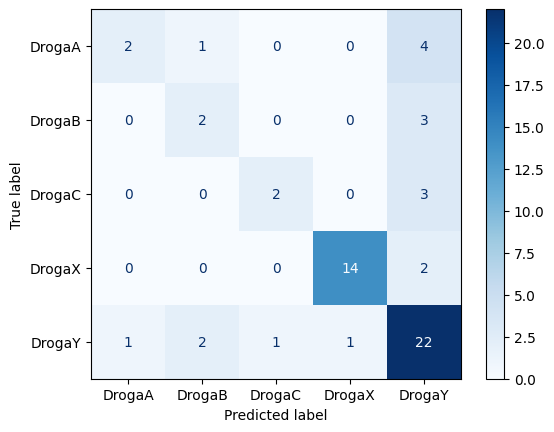

In [2323]:
ConfusionMatrixDisplay.from_predictions(y_test3, pred_MNB3, cmap=plt.cm.Blues);

## KNN

### Dataset 1 (80, 20)

**Mejor modelo**

In [2324]:
# Definimos los parámetros de cantidad de vecinos, métrica y valor de p
parametros_grid = {'n_neighbors':  range(1, 50, 10),
                   'p':[1,2],
                   'weights': ['uniform', 'distance'] }

grid_search1 = GridSearchCV(estimator = KNeighborsClassifier(),
                           param_grid = parametros_grid,
                           cv=5,
                           scoring='accuracy')

In [2325]:
# Realizar la búsqueda de hiperparámetros en el conjunto de entrenamiento
grid_search1.fit(X_train_scaled2, y_train2)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", grid_search1.best_params_)

# Obtener el mejor modelo entrenado
mejor_clasificador1 = grid_search1.best_estimator_

Mejores hiperparámetros: {'n_neighbors': 21, 'p': 1, 'weights': 'distance'}


Precisión del modelo: 0.97
Informe de Clasificación:
              precision    recall  f1-score   support

      DrogaA       0.83      1.00      0.91         5
      DrogaB       1.00      0.67      0.80         3
      DrogaC       1.00      1.00      1.00         3
      DrogaX       1.00      1.00      1.00        11
      DrogaY       1.00      1.00      1.00        18

    accuracy                           0.97        40
   macro avg       0.97      0.93      0.94        40
weighted avg       0.98      0.97      0.97        40



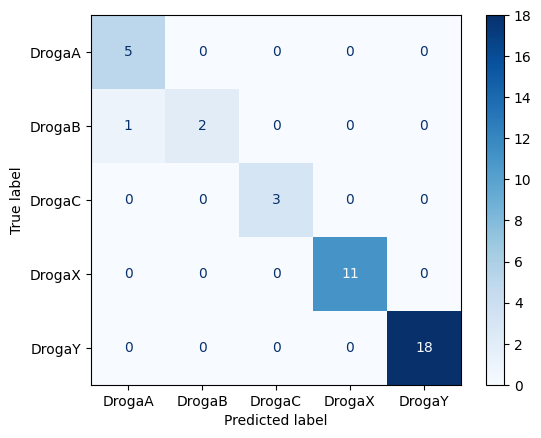

In [2326]:
# Realizar predicciones en el conjunto de prueba
pred_knn = mejor_clasificador1.predict(X_test_scaled2)

ConfusionMatrixDisplay.from_predictions(y_test2, pred_knn, cmap=plt.cm.Blues)

accuracy = accuracy_score(y_test2, pred_knn)
print(f'Precisión del modelo: {accuracy:.2f}')

# Mostrar el informe de clasificación
print('Informe de Clasificación:')
print(classification_report(y_test2, pred_knn))

### Dataset 2 (70, 30)

**Mejor modelo**

In [2327]:
# Definimos los parámetros de cantidad de vecinos, métrica y valor de p
parametros_grid = {'n_neighbors': range(1, 50, 10),
                   'p': [1,2],
                   'weights': ['uniform', 'distance'] }


grid_search = GridSearchCV(estimator = KNeighborsClassifier(),
                           param_grid = parametros_grid,
                           cv=5,
                           scoring='accuracy')

In [2328]:
# Realizar la búsqueda de hiperparámetros en el conjunto de entrenamiento
grid_search.fit(X_train_scaled3, y_train3)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", grid_search.best_params_)

# Obtener el mejor modelo entrenado
mejor_clasificador = grid_search.best_estimator_

Mejores hiperparámetros: {'n_neighbors': 31, 'p': 2, 'weights': 'distance'}


Precisión del modelo: 0.95
Informe de Clasificación:
              precision    recall  f1-score   support

      DrogaA       0.86      0.86      0.86         7
      DrogaB       1.00      0.80      0.89         5
      DrogaC       1.00      0.80      0.89         5
      DrogaX       1.00      1.00      1.00        16
      DrogaY       0.93      1.00      0.96        27

    accuracy                           0.95        60
   macro avg       0.96      0.89      0.92        60
weighted avg       0.95      0.95      0.95        60



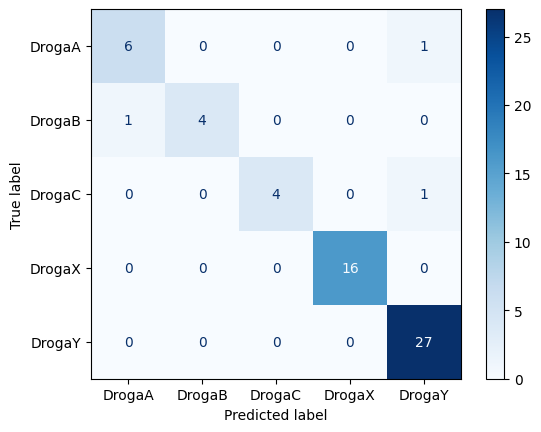

In [2329]:
# Realizar predicciones en el conjunto de prueba
pred_knn = mejor_clasificador.predict(X_test_scaled3)

ConfusionMatrixDisplay.from_predictions(y_test3, pred_knn, cmap=plt.cm.Blues)

accuracy = accuracy_score(y_test3, pred_knn)
print(f'Precisión del modelo: {accuracy:.2f}')

print('Informe de Clasificación:')
print(classification_report(y_test3, pred_knn))